# Constrained Vehicle Routing Problem with or-tools

Solution: Optimal
arc               Energy        Time    Distance
                   [kWh]       [min]        [km]
------------------------------------------------
(0, 1)              15.9        57.9       106.1
(1, 3)               7.2        26.3        48.3
(3, 5)              17.9        65.1       119.4
(5, 9)              16.8        61.2       112.2
(9, 11)             17.1        62.3       114.2
Node                c_in       c_out Charge Time
                     [%]         [%]       [min]
------------------------------------------------
0                               70.0            
1                   13.2        70.0        22.7
3                   44.3        73.9        13.8
5                   10.0        70.0        48.0
9                   10.0        71.1        49.6
11                  10.0                        
Objective Value: 446.9 (7 h 26 min)
Total Distance traveled: 500.2 km
Total Route Time: 7 h 26 min
Drive Time: 5 h 12 min
Charge Time: 2 h 14 min
Cha

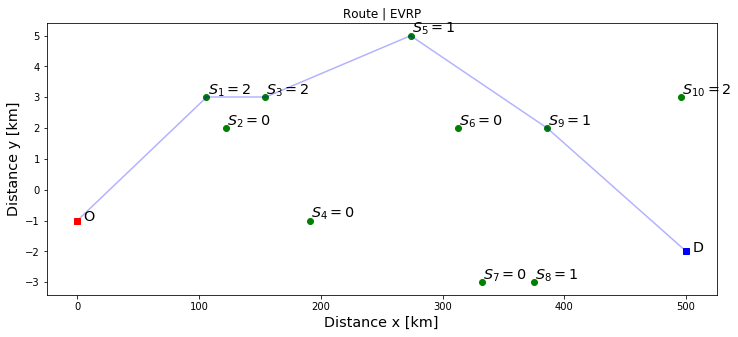

In [3]:
import numpy.random as rnd
import numpy as np
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

def create_data_model(speed, nr_cs=10):
    Q=28
    EC = 0.15 # Energy consumption kWh/km
    
    cs = [n+1 for n in range(nr_cs)] #cs vertices
    nodes = [0]+cs
    destination = len(nodes)
    nodes.append(destination) # append destination vertex to vertices

    X = 500 # total route length in km

    # Create coordinates:
    rnd = np.random
    rnd.seed(42)
    loc_x = np.sort([0]+[rnd.randint(0,X)+rnd.rand()*5 for n in range(nr_cs)]+[X]).round(1)
    loc_y = np.round([rnd.rand()*5*(1-2*rnd.randint(0,2)) for n in range(len(nodes))])

    arcs = {(i,j): {} for i in nodes for j in nodes if i<j}
    
    for (i,j) in arcs:
        
        arcs[(i,j)]['distance'] = round(np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])),1)
        arcs[(i,j)]['time'] = round(arcs[(i,j)]['distance']*60/speed,1) 
        arcs[(i,j)]['consumption'] = round(arcs[(i,j)]['distance']*EC,1) 
    
    inf_arc = [arc for arc in arcs if arcs[arc]['consumption'] > Q]

    for arc in inf_arc:
        del arcs[arc]

    return arcs, nodes, [loc_x,loc_y]

arcs, nodes, locs = create_data_model(110,10)
Q=28
q_ini = 0.7
q_min = 0.1
q_end = 0.1

M = 1000

station_charge_curves = {}
for i in nodes[1:-1]:
    rnd.seed(i+5)
    p =rnd.rand()
    if p > 0 and p < .5:
        s = 0
    elif p > .5 and p < .8:
        s=1
    else:
        s= 2
    station_charge_curves[i] = s

model = pywraplp.Solver('EVRP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
model.EnableOutput()

# define variables
#x = {arc:model.IntVar(0,1,'x[{}]'.format(arc)) for arc in arcs} 
x = {arc:model.BoolVar('x[{}]'.format(arc)) for arc in arcs} 
q = {arc:model.NumVar(0, Q, 'q[{}]'.format(arc)) for arc in arcs} 

c_in = {i:model.NumVar(q_min*Q, Q, 'c_in[{}]'.format(i)) for i in nodes[1:]} 

c_out = {i:model.NumVar(q_min*Q, Q, 'c_out[{}]'.format(i)) for i in nodes[:-1]} 

t_in = {i:model.NumVar(0, 500, 't_in[{}]'.format(i)) for i in nodes[1:-1]} 

t_out = {i:model.NumVar(0, 500, 't_out[{}]'.format(i)) for i in nodes[1:-1]} 

# objective function
model.Minimize(model.Sum(arcs[arc]['time']*x[arc] for arc in arcs)
#               + model.Sum(arcs[arc]['distance']*x[arc] for arc in arcs)
               + 10*(model.Sum(x[arc] for arc in arcs) -1)
#               + model.Sum(x[arc]*200 for arc in arcs)
               + model.Sum((t_out[i]-t_in[i]) for i in nodes [1:-1])
#               + model.Sum((t_out[i]-t_in[i]) for (i,j) in x if x[(i,j)] == 1 and i!=0)
              )
# define constraints

# consumption indicator constraint 
for arc in arcs:
    model.Add(q[arc] >= arcs[arc]['consumption'] - (1-x[arc])*M, 'C_{}'.format(arc))
    
# exit flow 
model.Add(model.Sum([x[0,j] for j in nodes if j !=0 and (0,j) in arcs]) == 1, 'flow0' )

# continuous flow
for i in nodes[1:-1]:
    model.Add(model.Sum(x[(j,i)] for j in nodes if i!=j and (j,i) in arcs) 
              == model.Sum(x[(i,j)] for j in nodes if i!=j and (i,j) in arcs), 'flow{}'.format(i)
             )
# how much to charge constraint
for (i,j) in arcs:
    model.Add((c_out[i] - c_in[j]) == q[(i,j)],'')

# initial battery level
model.Add(c_out[0] == q_ini*Q, '')
model.Add(c_in[nodes[-1]] == q_end*Q, '')

# define piecewise functions for charger speeds
y = lambda x, b1, b2: b1*x if x<70 else b2*x - 70*(b2 - b1)
soc = [0,70,100]
pw_slow = [soc, [y(i,1.2,2) for i in soc]]
pw_medium = [soc, [y(i,0.8,1.5) for i in soc]]
pw_fast = [soc, [y(i,0.4,0.9) for i in soc]]

pw_params = [pw_slow,pw_medium, pw_fast]

curves = {i:{} for i in nodes[1:-1]}

def Piecewise1(s, params):
    
    bp_x = params[0]
    bp_y = params[1]
    
    n = len(bp_x)

    #variables
    curves[s]['z_in'] = {i:model.BoolVar('z_in_{}[{}]'.format(i,s)) for i in range(n)}
    curves[s]['s_in'] = {i:model.NumVar(0,1,'s_in_{}[{}]'.format(i,s)) for i in range(n)}
    
    curves[s]['z_out'] = {i:model.BoolVar('z_out_{}[{}]'.format(i,s)) for i in range(n)}
    curves[s]['s_out'] = {i:model.NumVar(0,1,'s_out_{}[{}]'.format(i,s)) for i in range(n)}
    
    #define SOS2 constraints
    for i in curves[s]['s_in']:
        model.Add(curves[s]['s_in'][i]<=curves[s]['z_in'][i],'')
        model.Add(curves[s]['s_out'][i]<=curves[s]['z_out'][i],'')
    model.Add(model.Sum(curves[s]['s_in'][i] for i in curves[s]['s_in']) == 1,'')
    model.Add(model.Sum(curves[s]['z_in'][i] for i in curves[s]['z_in']) <= 2,'')
    model.Add(model.Sum(curves[s]['s_out'][i] for i in curves[s]['s_out']) == 1,'')
    model.Add(model.Sum(curves[s]['z_out'][i] for i in curves[s]['z_out']) <= 2,'')
    for i in curves[s]['z_in']:
        for j in curves[s]['z_in']:
            if i!=j and j!= i+1 and i<j:
                model.Add(curves[s]['z_in'][i]+curves[s]['z_in'][j]<=1,'')
                model.Add(curves[s]['z_out'][i]+curves[s]['z_out'][j]<=1,'')
                        
    model.Add(model.Sum(bp_x[i]*curves[s]['s_in'][i] for i in curves[s]['s_in']) == c_in[s]*100/Q,'')
    model.Add(model.Sum(bp_y[i]*curves[s]['s_in'][i] for i in curves[s]['s_in']) == t_in[s],'')
    model.Add(model.Sum(bp_x[i]*curves[s]['s_out'][i] for i in curves[s]['s_out']) == c_out[s]*100/Q,'')
    model.Add(model.Sum(bp_y[i]*curves[s]['s_out'][i] for i in curves[s]['s_out']) == t_out[s],'')

for i in nodes[1:-1]:
    Piecewise1(i,pw_params[station_charge_curves[i]])

for i in nodes[1:-1]:
    model.Add(t_out[i] >= t_in[i])
#print(model.ExportModelAsLpFormat(False))
model.set_time_limit(30000)

solution = model.Solve()
solution_type = {0:'Optimal', 1:'Feasible', 2: 'Infeasible', 6: 'Not Solved'}
print('Solution: {}'.format(solution_type[solution]))

active_arcs = [arc for arc in x if x[arc].SolutionValue()!=0]

width=12

print('{:=^{width}}'.format('',width=4*width))
print('{:{width}}{:>{width}}{:>{width}}{:>{width}}'.format('arc', 'Energy', 'Time', 'Distance', width=width))
print('{:{width}}{:>{width}}{:>{width}}{:>{width}}'.format('', '[kWh]', '[min]', '[km]', width=width))
print('{:-^{width}}'.format('',width=4*width))
for arc in active_arcs:
    print('{:{width}}{:{width}}{:{width}}{:{width}}'.format(
        str(arc), arcs[arc]['consumption'], arcs[arc]['time'], arcs[arc]['distance'], width=width))
print('{:=^{width}}'.format('',width=4*width))

active_nodes = list(set(np.array([ arc for arc in active_arcs]).flatten()))
active_nodes.sort()
_
print('{:=^{width}}'.format('',width=4*width))
print('{:{width}}{:>{width}}{:>{width}}{:>{width}}'.format('Node', 'c_in', 'c_out','Charge Time', width=width))
print('{:{width}}{:>{width}}{:>{width}}{:>{width}}'.format('', '[%]', '[%]','[min]', width=width))
print('{:-^{width}}'.format('',width=4*width))
for i in active_nodes:
    if i not in c_in:
        print('{:<{width}}{:>{width}}{:>{width}.1f}{:>{width}}'.format(
            i, '', c_out[i].solution_value()*100/Q,'', width=width))
    elif i in c_in and i in c_out:
        print('{:<{width}}{:{width}.1f}{:{width}.1f}{:>{width}.1f}'.format(
            i, c_in[i].solution_value()*100/Q, c_out[i].solution_value()*100/Q,(t_out[i].SolutionValue()-t_in[i].SolutionValue()), width=width))
    else:
        print('{:<{width}}{:>{width}.1f}{:>{width}}{:>{width}}'.format(i, c_in[i].solution_value()*100/Q, '','', width=width))
print('{:=^{width}}'.format('',width=4*width))

obj = model.Objective().Value()
obj_time = divmod(obj,60)
print('Objective Value: {:.1f} ({} h {} min)'.format(obj, int(obj_time[0]), int(obj_time[1])))

loc_x = locs[0]
loc_y = locs[1]
plt.figure(figsize=(12,5))
plt.scatter(loc_x,loc_y,color="green")

for i in nodes[1:-1]:
    plt.annotate('$S_{{{}}}={}$'.format(i, station_charge_curves[i]),(loc_x[i]+1,loc_y[i]+0.1), fontsize='x-large')

for i,j in active_arcs:
    plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],color="blue",alpha=0.3)

plt.plot(loc_x[0],loc_y[0],color='red',marker='s')
plt.annotate('O', (loc_x[0]+5, loc_y[0]), fontsize='x-large')
plt.plot(loc_x[-1], loc_y[-1], color='blue', marker='s')
plt.annotate('D', (loc_x[-1]+5, loc_y[-1]), fontsize='x-large')

plt.xlabel("Distance x [km]", fontsize='x-large')
plt.ylabel("Distance y [km]", fontsize='x-large')
plt.title("Route | EVRP")

chargeTimeAll = divmod(sum(t_out[i].SolutionValue()-t_in[i].SolutionValue() for i in nodes[1:-1]),60)
chargeTime = divmod(sum(t_out[i].SolutionValue()-t_in[i].SolutionValue() for i in active_nodes[1:-1]), 60)
driveTime = divmod(sum([arcs[arc]['time'] for arc in active_arcs])+ (len(active_arcs)-1)*10, 60)
routeTime = sum(t_out[i].SolutionValue()-t_in[i].SolutionValue() for i in active_nodes[1:-1]) \
            + sum([arcs[arc]['time'] for arc in active_arcs])+ (len(active_arcs)-1)*10

routeTime = divmod(routeTime, 60)
tot_dis = sum(arcs[arc]['distance'] for arc in active_arcs )

print('Total Distance traveled: {:.1f} km'.format(tot_dis))
print(f'Total Route Time: {int(routeTime[0])} h {int(routeTime[1])} min')
print(f'Drive Time: {int(driveTime[0])} h {int(driveTime[1])} min')
print(f'Charge Time: {int(chargeTime[0])} h {int(chargeTime[1])} min')
print(f'Charge Time All: {int(chargeTimeAll[0])} h {int(chargeTimeAll[1])} min')
print('Nr. Constraints: {}'.format(model.NumConstraints()))
print('Nr. Variables: {}'.format(model.NumVariables()))

# get Piecewise fits for OR-Tools

In [ ]:
# collect charging data for Hyundai Ioniq and generate charging curves
hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select while charging data, for Hyundai the conditions are as below
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2019,12,1))

#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

# collect charging data as AutoCharge objects
hyundai_charges = collect_charges(hyundai[mask], peaks_id)

# getcharging curves
HyundaiCharges = ChargingCurve(hyundai_charges)

def getMedianChargeCurve(data, temp = False):
        """
        Function to determine the median value at a constant SoC, by aggregating
        the power values in 1 % SoC bins.
        
        Returns a panda DataFrame with median values of Power and Charging time in minutes
        at 1 % bins.
        """
        cols = ['soc_display','power']
        bins = pd.IntervalIndex.from_tuples([(i, i+1)  for i in range(100)])
        
        if temp:
            mask = (data.BatteryTemp == temp)
            dff = data[cols][mask]
        else:
            dff = data[cols]
            
        dff['ranges'] = pd.cut(dff['soc_display'], bins = bins)
    
        medians = dff.groupby('ranges').median()
        medians['remainingTime'] = battCapacity*(1-medians['soc_display'][1:]/100)/medians['power'][1:]
        medians['elapsedTime'] = abs((medians['remainingTime']*60).diff(1)).cumsum()
        medians['elapsedTime'] = medians['elapsedTime'] - medians['elapsedTime'].min()
        medians=medians.dropna()
        
        interpolated = interp1d(medians.soc_display, medians.power)

        medians_interp = pd.DataFrame([x for x in np.linspace(medians.soc_display.min(), 
                                                              medians.soc_display.max())],
                                      columns=['soc_display'])
        
        medians_interp['power'] = interpolated(medians_interp.soc_display)
        medians_interp['remainingTime'] = battCapacity*(1-medians_interp.soc_display/100)/interpolated(medians_interp.soc_display)
        medians_interp['elapsedTime'] = abs((medians_interp['remainingTime']*60).diff(1)).cumsum()
        medians_interp['elapsedTime'] = medians_interp['elapsedTime'] - medians_interp['elapsedTime'].min()
        medians_interp=medians_interp.dropna()
        
        return medians_interp
    
battCapacity = 28         
curve50kW = HyundaiCharges.ChargePowerCurve(50,battCapacity=28)    
curve100kW = HyundaiCharges.ChargePowerCurve(86,battCapacity=28)    
curve150kW = HyundaiCharges.ChargePowerCurve(160,battCapacity=28)    
curve350kW = HyundaiCharges.ChargePowerCurve(350,battCapacity=28)    

mediancurve50kW = getMedianChargeCurve(curve50kW)
mediancurve100kW = getMedianChargeCurve(curve100kW)
mediancurve150kW = getMedianChargeCurve(curve150kW)
mediancurve350kW = getMedianChargeCurve(curve350kW)

legends = {0: '50 kW', 1: '100 kW', 2: '150 kW', 3: '350 kW'}
curves = [mediancurve50kW,mediancurve100kW, mediancurve150kW, mediancurve350kW]

import pwlf
# list of instatiated piecewise curves
pwf_list = [pwlf.PiecewiseLinFit(curve.soc_display, curve.elapsedTime) for curve in curves]

# fit the curves with 4 linear segments
for curve in pwf_list:
    curve.fit(4)

# generate dictionary with piecewise parameters for the curves to use with OR-TOOLS

pwf_ortools_params = []
for pw in pwf_list:
    bp_x = np.append(0,np.append(pw.fit_breaks[1:-1], 100))
    bp_y = np.array([pw.predict(bp)[0] for bp in bp_x])
    bp_y = bp_y - bp_y.min()

    pwf_ortools_params.append([bp_x, bp_y])
    
pwf_ortools_params_dic = {power: pwf_ortools_params[i] for i, power in  enumerate([50,100,150,350])}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

rnd = np.random

Route for vehicle 0:
 0 Load(0) ->  1 Load(6) ->  8 Load(9) ->  7 Load(15) ->  0 Load(15)
Distance of the route: 180m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  3 Load(4) ->  5 Load(12) ->  0 Load(12)
Distance of the route: 119m
Load of the route: 12

Route for vehicle 2:
 0 Load(0) ->  6 Load(4) ->  9 Load(9) ->  4 Load(13) ->  0 Load(13)
Distance of the route: 194m
Load of the route: 13

Route for vehicle 3:
 0 Load(0) ->  10 Load(8) ->  2 Load(9) ->  0 Load(9)
Distance of the route: 135m
Load of the route: 9

Total distance of all routes: 628m
Total load of all routes: 49


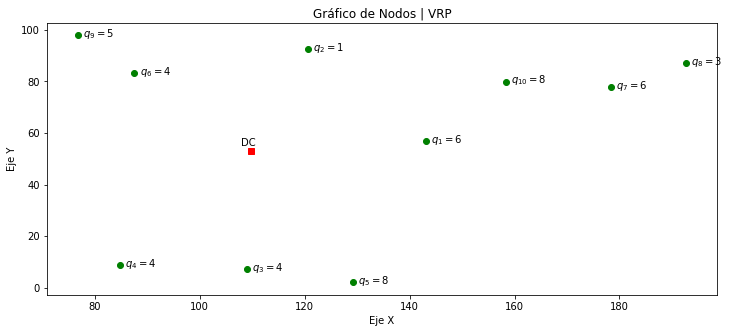

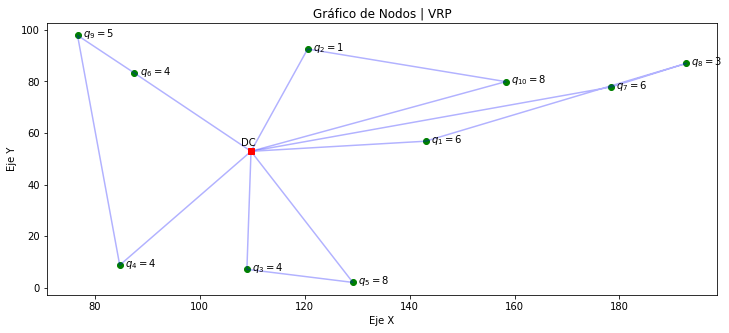

In [2]:
n=10 # Clientes
clientes=[x for x in range(1,n+1)]

nodos=[0]+clientes
Q=15

# Crear coordenadas 
rnd.seed(0)
loc_x=rnd.rand(len(nodos))*200
loc_y=rnd.rand(len(nodos))*100
rnd.seed(0)
demands = [0]+[rnd.randint(1,10) for i in clientes]

plt.figure(figsize=(12,5))
plt.scatter(loc_x,loc_y,color="green")

for i in clientes:
    plt.annotate('$q_{%d}=%d$'%(i,demands[i]),(loc_x[i]+1,loc_y[i]-0.5))
    
plt.plot(loc_x[0],loc_y[0],color='red',marker='s')
plt.annotate('DC',(loc_x[0]-2,loc_y[0]+2))

plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Gráfico de Nodos | VRP")

def create_data_model():
    data = {}
    data['distance_matrix'] =[[np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])) for i in nodos] 
                     for j in nodos] 
    data['num_vehicles'] = 4
    data['depot'] = 0
    data['vehicle_capacities'] = [15,15,15,15]
    data['demands'] = demands
    return data
    
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

def plot_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    route_idx =[]
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        r_idx =  []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            r_idx.append(node_index)
        r_idx.append(0)
        route_idx.append(r_idx)
        
    plt.figure(figsize=(12,5))
    plt.scatter(loc_x,loc_y,color="green")

    for route in route_idx:
        plt.plot(loc_x[route],loc_y[route],color="blue", alpha=0.3)

    for i in clientes:
        plt.annotate('$q_{%d}=%d$'%(i,data['demands'][i]),(loc_x[i]+1,loc_y[i]-0.5))

    plt.plot(loc_x[0],loc_y[0],color='red',marker='s')
    plt.annotate('DC',(loc_x[0]-2,loc_y[0]+2))

    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Gráfico de Nodos | VRP")
    
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        plot_solution(data, manager, routing, solution)


    else:
        print('no solution')

#    return routing, solution
main()

# Open VRP

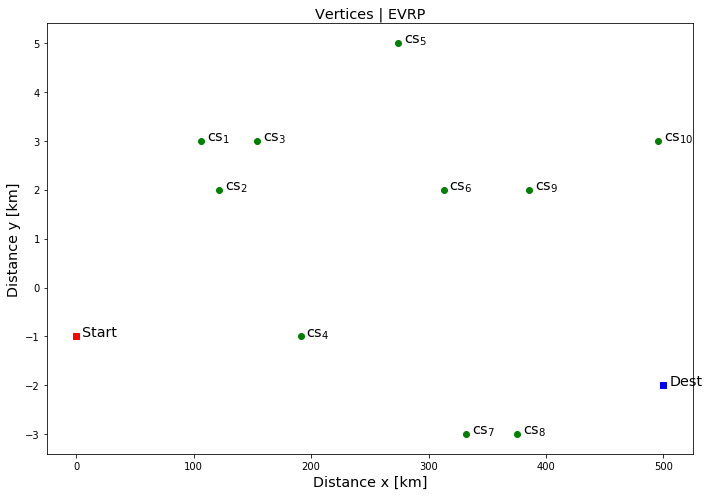

In [3]:
n_cs = 10 # number of charge stations
cs = [n+1 for n in range(n_cs)] #cs vertices
vertices = [0]+cs
destination = len(vertices)
vertices.append(destination) # append destination vertex to vertices

Q = 28 # EV Battery capacity
EC = 0.15 # Energy consumption kWh/km
speed = 110 # km/h

X = 500 # total route length in km

# Create coordinates:
rnd = np.random
rnd.seed(42)
loc_x = np.sort([0]+[rnd.randint(0,X)+rnd.rand()*5 for n in range(n_cs)]+[X]).round(1)
loc_y = np.round([rnd.rand()*5*(1-2*rnd.randint(0,2)) for n in range(len(vertices))])

#plot vertices
plt.figure(figsize=(10,7))
plt.plot(loc_x[cs], loc_y[cs], 'o', color='green')
plt.plot(loc_x[0], loc_y[0], 'o', marker='s',color='red')
plt.plot(loc_x[destination], loc_y[destination], 'o', marker='s',c='blue')
for i in cs:
    plt.annotate(r'cs$_{{{}}}$'.format(i), (loc_x[i]+5, loc_y[i]), fontsize='x-large')
plt.annotate('Start', (loc_x[0]+5, loc_y[0]), fontsize='x-large')
plt.annotate('Dest', (loc_x[destination]+5, loc_y[destination]), fontsize='x-large')
plt.xlabel('Distance x [km]', fontsize='x-large')
plt.ylabel('Distance y [km]', fontsize='x-large')
plt.title('Vertices | EVRP', fontsize='x-large')
plt.tight_layout()


In [33]:
def create_data_model(vehicles, mode=1):
    data = {}
    
    if mode == 1:
        data['distance_matrix'] =[[np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])) for i in vertices] 
                     for j in vertices] 
    else:
        data['distance_matrix'] =[[np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])) if i>j else 0 
                                   for i in vertices]                   
                                  for j in vertices] 
    data['num_vehicles'] = vehicles
    data['depot'] = 0
    data['vehicle_capacities'] = [15 for n in range(vehicles)]
    rnd.seed(42)
    data['demands'] = [0]+[rnd.randint(1,10) for n in range(len(vertices)-2)]+[0]
    data['start'] = [0 for n in range(vehicles)]
    data['end'] = [11 for n in range(vehicles)]
    return data    

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

def plot_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    route_idx =[]
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        r_idx =  []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            r_idx.append(node_index)
        r_idx.append(11)
        route_idx.append(r_idx)
        
    plt.figure(figsize=(12,5))
    plt.scatter(loc_x,loc_y,color="green")
    
    for i, route in enumerate(route_idx):
        plt.plot(loc_x[route],loc_y[route], alpha=0.3, label='vehicle {}'.format(i))

    for i in cs:
        plt.annotate('$q_{%d}=%d$'%(i,data['demands'][i]),(loc_x[i]+1,loc_y[i]+0.1), fontsize='x-large')

    plt.plot(loc_x[0],loc_y[0],color='red',marker='s')
    plt.annotate('Start', (loc_x[0]+5, loc_y[0]), fontsize='x-large')
    plt.plot(loc_x[-1], loc_y[-1], color='blue', marker='s')
    plt.annotate('Dest', (loc_x[destination]+5, loc_y[destination]), fontsize='x-large')
    plt.legend()

    plt.xlabel("Distance x [km]", fontsize='x-large')
    plt.xlabel("Distance y [km]", fontsize='x-large')
    plt.title("Routes | OVRP")
    
def main(vehicles,mode=1):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(vehicles, mode)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['start'], data['end'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        plot_solution(data, manager, routing, solution)


    else:
        print('no solution')

#    return routing, solution


Route for vehicle 0:
 0 Load(0) ->  7 Load(7) ->  8 Load(15) ->  11 Load(15)
Distance of the route: 499m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  4 Load(5) ->  9 Load(10) ->  10 Load(14) ->  11 Load(14)
Distance of the route: 500m
Load of the route: 14

Route for vehicle 2:
 0 Load(0) ->  3 Load(8) ->  5 Load(15) ->  11 Load(15)
Distance of the route: 499m
Load of the route: 15

Route for vehicle 3:
 0 Load(0) ->  1 Load(7) ->  2 Load(11) ->  6 Load(14) ->  11 Load(14)
Distance of the route: 499m
Load of the route: 14

Total distance of all routes: 1997m
Total load of all routes: 58


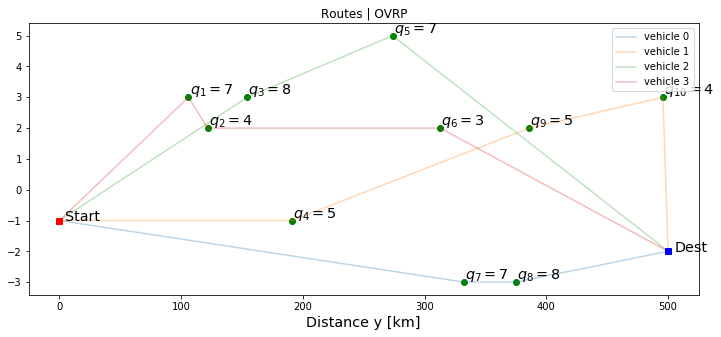

In [5]:
main(vehicles=4,mode=1)

# Drop visits to CS

Dropped nodes: 3 5 7 8 10 11 12 14 15
Route for vehicle 0:
 0 Load(0) 0min ->  4 Load(5) 92min ->  9 Load(10) 170min ->  13 Load(13) 209min ->  16 Load(13)
Time of the route: 271min
Load of the route: 13

Route for vehicle 1:
 0 Load(0) 0min ->  1 Load(7) 57min ->  2 Load(11) 66min ->  6 Load(14) 127min ->  16 Load(14)
Time of the route: 271min
Load of the route: 14

Total Time of all routes: 542min
Total Load of all routes: 27
[[0, 4, 9, 13, 16], [0, 1, 2, 6, 16]]


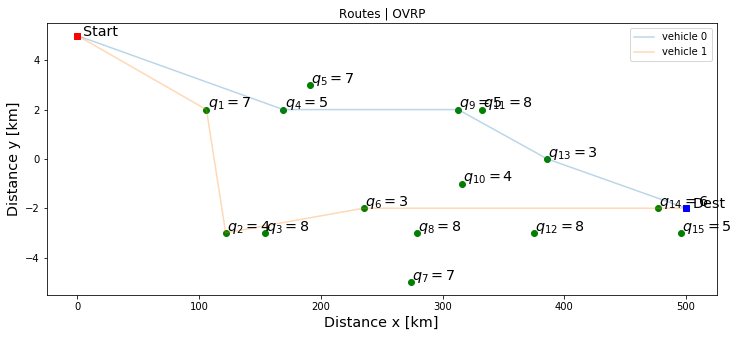

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

rnd = np.random



def create_data_model(stations, vehicles, mode):
    data = {}

    n_cs = stations # number of charge stations
    cs = [n+1 for n in range(n_cs)] #cs vertices
    vertices = [0]+cs
    destination = len(vertices)
    vertices.append(destination) # append destination vertex to vertices

    Q = 28 # EV Battery capacity
    EC = 0.15 # Energy consumption kWh/km
    speed = 110 # km/h

    X = 500 # total route length in km

    # Create coordinates:
    rnd = np.random
    rnd.seed(42)
    data['loc_x'] = np.sort([0]+[rnd.randint(0,X)+rnd.rand()*5 for n in range(n_cs)]+[X]).round(1)
    data['loc_y'] = np.round([rnd.rand()*5*(1-2*rnd.randint(0,2)) for n in range(len(vertices))])  
    
    if mode == 1:
        data['distance_matrix'] =[[np.hypot((data['loc_x'][i]-data['loc_x'][j]),(data['loc_y'][i]-data['loc_y'][j])) 
                                   for i in vertices] 
                                  for j in vertices] 
    elif mode == 2:
        data['distance_matrix'] =[[np.hypot((data['loc_x'][i]-data['loc_x'][j]),(data['loc_y'][i]-data['loc_y'][j]))
                                   if i>j else 0 for i in vertices]                   
                                  for j in vertices] 
        
    data['time_matrix'] = np.array(data['distance_matrix'])*60/speed
    data['num_vehicles'] = vehicles
    data['depot'] = 0
    data['vehicle_capacities'] = [15 for n in range(vehicles)]
    rnd.seed(42)
    data['demands'] = [0]+[rnd.randint(1,10) for n in range(len(vertices)-2)]+[0]
    data['start'] = [0 for n in range(vehicles)]
    data['end'] = [len(vertices)-1 for n in range(vehicles)]
    return data   

def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    # Display routes
    total_time = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_time = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) {2}min -> '.format(node_index, route_load, route_time)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_time += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Time of the route: {}min\n'.format(route_time)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_time += route_time
        total_load += route_load
    print('Total Time of all routes: {}min'.format(total_time))
    print('Total Load of all routes: {}'.format(total_load))

def plot_solution(data, manager, routing, solution):
    route_idx =[]
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        r_idx =  []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            index = solution.Value(routing.NextVar(index))
            r_idx.append(node_index)
        r_idx.append(len(data['distance_matrix'])-1)
        route_idx.append(r_idx)
        
    plt.figure(figsize=(12,5))
    plt.scatter(data['loc_x'],data['loc_y'],color="green")
    print(route_idx)
    for i, route in enumerate(route_idx):
        plt.plot(data['loc_x'][route],data['loc_y'][route], alpha=0.3, label='vehicle {}'.format(i))

    for i in range(1,len(data['distance_matrix'])-1):
        plt.annotate('$q_{{{}}}={}$'.format(i,data['demands'][i]),(data['loc_x'][i]+1,data['loc_y'][i]+0.1), fontsize='x-large')

    plt.plot(data['loc_x'][0],data['loc_y'][0],color='red',marker='s')
    plt.annotate('Start', (data['loc_x'][0]+5, data['loc_y'][0]), fontsize='x-large')
    plt.plot(data['loc_x'][-1], data['loc_y'][-1], color='blue', marker='s')
    plt.annotate('Dest', (data['loc_x'][-1]+5, data['loc_y'][-1]), fontsize='x-large')
    plt.legend()

    plt.xlabel("Distance x [km]", fontsize='x-large')
    plt.ylabel("Distance y [km]", fontsize='x-large')
    plt.title("Routes | OVRP")
    
def main(stations, vehicles, mode):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(stations, vehicles, mode)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['start'], data['end'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    # Allow to drop nodes.
    penalty = 1000
    for node in range(1, len(data['distance_matrix'])-1):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(data, manager, routing, assignment)
        plot_solution(data, manager, routing, assignment)
    else:
        print('No solution')
        
main(stations=15,vehicles=2, mode=1)

Dropped nodes: 3 5 7 8 10 11 12 14 15
Route for vehicle 0:
 0 Load(0) 0min ->  4 Load(5) 92min ->  9 Load(10) 170min ->  13 Load(13) 209min ->  16 Load(13)
Time of the route: 271min
Load of the route: 13

Route for vehicle 1:
 0 Load(0) 0min ->  1 Load(7) 57min ->  2 Load(11) 66min ->  6 Load(14) 127min ->  16 Load(14)
Time of the route: 271min
Load of the route: 14

Total Time of all routes: 542min
Total Load of all routes: 27
[[0, 4, 9, 13, 16], [0, 1, 2, 6, 16]]


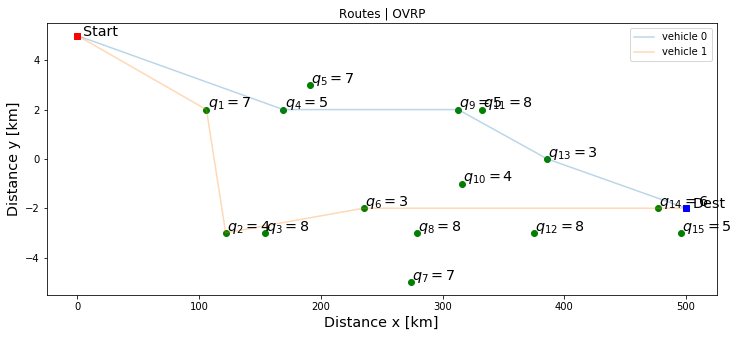

In [7]:
main(stations=15,vehicles=2, mode=2)

# MILP approach

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from ortools.linear_solver import pywraplp
from ortools.constraint_solver import routing_enums_pb2

rnd = np.random

solver = pywraplp.Solver('MILP',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

def create_data_model(stations, vehicles, mode):
    data = {}

    n_cs = stations # number of charge stations
    cs = [n+1 for n in range(n_cs)] #cs vertices
    vertices = [0]+cs
    destination = len(vertices)
    vertices.append(destination) # append destination vertex to vertices

    Battery_capacity = 28 # EV Battery capacity
    EC = 0.15 # Energy consumption kWh/km
    speed = 110 # km/h

    X = 500 # total route length in km

    # Create coordinates:
    rnd = np.random
    rnd.seed(42)
    data['loc_x'] = np.sort([0]+[rnd.randint(0,X)+rnd.rand()*5 for n in range(n_cs)]+[X]).round(1)
    data['loc_y'] = np.round([rnd.rand()*5*(1-2*rnd.randint(0,2)) for n in range(len(vertices))])  
    
    if mode == 1:
        data['distance_matrix'] =[[np.hypot((data['loc_x'][i]-data['loc_x'][j]),(data['loc_y'][i]-data['loc_y'][j])) 
                                   for i in vertices] 
                                  for j in vertices] 
    elif mode == 2:
        data['distance_matrix'] =[[np.hypot((data['loc_x'][i]-data['loc_x'][j]),(data['loc_y'][i]-data['loc_y'][j]))
                                   if i>j else 0 for i in vertices]                   
                                  for j in vertices] 
        
    data['time_matrix'] = np.array(data['distance_matrix'])*60/speed
    data['e_consumption_matrix'] = np.array(data['distance_matrix'])*EC
    print(np.round(data['e_consumption_matrix'], 1))
    data['num_vehicles'] = vehicles
    data['depot'] = 0
    data['vehicle_capacities'] = [15 for n in range(vehicles)]
    rnd.seed(42)
    data['demands'] = [0]+[rnd.randint(1,10) for n in range(len(vertices)-2)]+[0]
    data['start'] = [0 for n in range(vehicles)]
    data['end'] = [len(vertices)-1 for n in range(vehicles)]
    data['battery_capacity'] = battery_capacity
    return data   

def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    # Display routes
    total_time = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_time = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) {2}min -> '.format(node_index, route_load, route_time)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_time += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Time of the route: {}min\n'.format(route_time)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_time += route_time
        total_load += route_load
    print('Total Time of all routes: {}min'.format(total_time))
    print('Total Load of all routes: {}'.format(total_load))

def plot_solution(data, manager, routing, solution):
    route_idx =[]
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        r_idx =  []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            index = solution.Value(routing.NextVar(index))
            r_idx.append(node_index)
        r_idx.append(len(data['distance_matrix'])-1)
        route_idx.append(r_idx)
        
    plt.figure(figsize=(12,5))
    plt.scatter(data['loc_x'],data['loc_y'],color="green")
    print(route_idx)
    for i, route in enumerate(route_idx):
        plt.plot(data['loc_x'][route],data['loc_y'][route], alpha=0.3, label='vehicle {}'.format(i))

    for i in range(1,len(data['distance_matrix'])-1):
        plt.annotate('$q_{{{}}}={}$'.format(i,data['demands'][i]),(data['loc_x'][i]+1,data['loc_y'][i]+0.1), fontsize='x-large')

    plt.plot(data['loc_x'][0],data['loc_y'][0],color='red',marker='s')
    plt.annotate('Start', (data['loc_x'][0]+5, data['loc_y'][0]), fontsize='x-large')
    plt.plot(data['loc_x'][-1], data['loc_y'][-1], color='blue', marker='s')
    plt.annotate('Dest', (data['loc_x'][-1]+5, data['loc_y'][-1]), fontsize='x-large')
    plt.legend()

    plt.xlabel("Distance x [km]", fontsize='x-large')
    plt.ylabel("Distance y [km]", fontsize='x-large')
    plt.title("Routes | OVRP")
    
def main(stations, vehicles, mode):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(stations, vehicles, mode)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['start'], data['end'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add E consumption constraint.
    def consumption_callback(from_index, to_index):
        """Returns the energy consumption between two nodes."""
        # Convert from routing variable Index to consuption matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['e_consumption_matrix'][from_node][to_node]
        
    consumption_callback_index = routing.RegisterUnaryTransitCallback(
        consumption_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['battery_capacities'],  # vehicle maximum battery capacity
        False,  # start cumul to zero
        'BatteryCapacity')
    
    # Allow to drop nodes.
    penalty = 1000
    for node in range(1, len(data['distance_matrix'])-1):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(data, manager, routing, assignment)
        plot_solution(data, manager, routing, assignment)
    else:
        print('No solution')
        
main(stations=10,vehicles=2, mode=1)

[[ 0.  15.9 18.3 23.2 28.6 41.1 46.9 49.8 56.3 57.9 74.4 75. ]
 [15.9  0.   2.4  7.2 12.8 25.2 31.  34.  40.4 42.  58.5 59.1]
 [18.3  2.4  0.   4.9 10.4 22.8 28.6 31.6 38.  39.6 56.1 56.7]
 [23.2  7.2  4.9  0.   5.5 17.9 23.8 26.7 33.1 34.7 51.2 51.9]
 [28.6 12.8 10.4  5.5  0.  12.4 18.3 21.2 27.6 29.2 45.7 46.4]
 [41.1 25.2 22.8 17.9 12.4  0.   5.9  8.9 15.2 16.8 33.3 34. ]
 [46.9 31.  28.6 23.8 18.3  5.9  0.   3.   9.4 11.  27.4 28.1]
 [49.8 34.  31.6 26.7 21.2  8.9  3.   0.   6.4  8.1 24.5 25.2]
 [56.3 40.4 38.  33.1 27.6 15.2  9.4  6.4  0.   1.8 18.1 18.8]
 [57.9 42.  39.6 34.7 29.2 16.8 11.   8.1  1.8  0.  16.5 17.1]
 [74.4 58.5 56.1 51.2 45.7 33.3 27.4 24.5 18.1 16.5  0.   1. ]
 [75.  59.1 56.7 51.9 46.4 34.  28.1 25.2 18.8 17.1  1.   0. ]]


NameError: name 'battery_capacity' is not defined

In [ ]:
_ = create_data_model(stations=5, vehicles=1, mode=1)
sum(np.round(_['times'], 1))

In [32]:
from ortools.linear_solver import pywraplp
def create_data_model():
    
    data = {}
    
    n=10 # Clientes
    data['clientes']=[x for x in range(1,n+1)]

    data['nodos']=[0]+data['clientes']
    
    data['Q'] = 15

    # Crear coordenadas 
    rnd.seed(0)
    data['loc_x'] = rnd.rand(len(data['nodos']))*200
    data['loc_y'] = rnd.rand(len(data['nodos']))*100
    
    data['distance_matrix'] =[[np.hypot((data['loc_x'][i]-data['loc_x'][j]),(data['loc_y'][i]-data['loc_y'][j])) 
                                   for i in data['nodos']] 
                                  for j in data['nodos']] 

    rnd.seed(0)
    data['demands'] = [0]+[rnd.randint(1,10) for i in data['clientes']]

    return data  

solver = pywraplp.Solver('simple_mip_program', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

data = create_data_model()
data['x'] = [[solver.BoolVar('x({},{})'.format(i,j)) for j in data['nodos']] for i in data['nodos']]
data['u'] = [solver.NumVar(0,Q,'u({})'.format(i)) for i in data['nodos']]


print('Number of variables =', solver.NumVariables())

# objective
solver.Minimize(sum(data['x'][i][j]*data['distance_matrix'][i][j] for j in data['nodos']  
                    for i in data['nodos'] if i!=j))
        
# Create the constraints
# sum along rows ==1
rows = [[data['x'][i][j] for j in data['clientes'] if i!=j] for i in data['clientes'] ]
for row in rows:
    solver.Add(sum(row) == 1)

# sum along cols ==1
cols = [[data['x'][i][j] for i in data['clientes'] if i!=j] for j in data['clientes']]

for col in cols:
    solver.Add(sum(col) == 1)

for i in data['nodos']:
    for j in data['nodos']:
        if i!=j:
            solver.Add(data['u'][i]+data['demands'][j] == data['u'][j])
        
for i in data['clientes']:
    solver.Add(data['u'][i]>=data['demands'][i])

print('Number of Constraints =', solver.NumConstraints())

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())

else:
    print('The problem does not have an optimal solution.')
    
tot=[]
for i in data['nodos']:
    for j in data['nodos']:
        
        if data['x'][i][j].solution_value() !=0 and i!=j:
            tot.append(data['distance_matrix'][i][j])
            print('{}: {} {:.1f}km'.format(data['x'][i][j].name(), data['x'][i][j].solution_value(), 
                                       data['distance_matrix'][i][j]))
print('tot: {}'.format(sum(tot)))
[[data['x'][i][j].solution_value() for i in data['nodos'] ] for j in data['nodos']]


Number of variables = 132
Number of Constraints = 140
The problem does not have an optimal solution.
tot: 0


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [29]:
data['u']

[u(0), u(1), u(2), u(3), u(4), u(5), u(6), u(7), u(8), u(9), u(10)]

In [16]:
from ortools.sat.python import cp_model
def create_data_model():
    
    data = {}
    
    n=10 # Clientes
    data['clientes']=[x for x in range(1,n+1)]

    data['nodos']=[0]+data['clientes']
    
    data['Q'] = 15

    # Crear coordenadas 
    rnd.seed(0)
    data['loc_x'] = rnd.rand(len(data['nodos']))*200
    data['loc_y'] = rnd.rand(len(data['nodos']))*100
    
    data['distance_matrix'] =[[np.hypot((data['loc_x'][i]-data['loc_x'][j]),(data['loc_y'][i]-data['loc_y'][j])) 
                                   for j in data['nodos']] 
                                  for i in data['nodos']] 

    rnd.seed(0)
    data['demands'] = [0]+[rnd.randint(1,10) for i in data['clientes']]

    return data  

data = create_data_model()

# create model
model = cp_model.CpModel()

data['x'] = [[model.NewBoolVar('x({},{})'.format(i,j)) for j in data['nodos']] for i in data['nodos']]
data['u'] = [model.NewIntVar(0,data['Q'],'u({})'.format(i)) for i in data['nodos']]
             
#data['intervals'] = [[model.NewOptionalIntervalVar(data['u'][i],
#                                                   data['demands'][j], 
#                                                   data['u'][j], 
#                                                   data['x'][i][j], 
#                                                   'interval({},{})'.format(i,j), 
#                                                  ) 
#                      for j in data['nodos'] if j !=0] for i in data['nodos'] if i!=0 ]

#data['cum']= [[model.AddCumulative([data['intervals'][i][j]], [data['demands'][j]],data['Q'])
#               for j in data['nodos']] for i in data['nodos'] ]
       
# Create the constraints
# sum along rows ==1
rows = [[data['x'][i][j] for j in data['clientes'] if i!=j] for i in data['clientes'] ]
for row in rows:
    model.Add(sum(row) == 1)

#dep_out = [data['x'][i][0] for i in data['clientes']]
#model.Add(sum(dep_out) > 1)

#dep_in = [data['x'][0][j] for j in data['clientes']]
#model.Add(sum(dep_in) > 1)
    
# sum along cols ==1
cols = [[data['x'][i][j] for i in data['clientes'] if i!=j] for j in data['clientes']]
for col in cols:
    model.Add(sum(col) == 1)

for i in data['nodos']:
    for j in data['nodos']:
        if i!=0 and j!=0:
            model.Add(data['u'][i]+data['demands'][j] == data['u'][j]).OnlyEnforceIf(data['x'][i][j])    

for i in data['clientes']:
    model.Add(data['u'][i]>=data['demands'][i])            

# objective
model.Minimize(sum(data['x'][i][j]*int(np.round(data['distance_matrix'][i][j])) for j in data['nodos']  
                    for i in data['nodos'] if i!=j))

    
solver = cp_model.CpSolver()
status = solver.Solve(model)    

print("validation: " +  model.ModelStats())

solution_printer = cp_model.ObjectiveSolutionPrinter()
solver.SolveWithSolutionCallback(model, solution_printer)
print(solver.ResponseStats())

#status = solver.Solve()
tot=[]
for i in data['nodos']:
    for j in data['nodos']:
        
        if solver.Value(data['x'][i][j]) !=0 and i!=j:
            tot.append(data['distance_matrix'][i][j])
            print('({},{}): {} {:.1f}km'.format(i,j, solver.Value(data['x'][i][j]), 
                                       data['distance_matrix'][i][j]))
print('tot: {}'.format(sum(tot)))
[[solver.Value(data['x'][i][j]) for i in data['nodos']]  for j in data['nodos']]

validation: Optimization model '':
#Variables: 132 (110 in objective)
 - 121 in [0,1]
 - 11 in [0,15]
#kLinear1: 20 (#enforced: 10)
#kLinear2: 90 (#enforced: 90)
#kLinearN: 20
CpSolverResponse:
status: INFEASIBLE
objective: NA
best_bound: NA
booleans: 0
conflicts: 0
branches: 0
propagations: 0
integer_propagations: 0
walltime: 0.00236392
usertime: 0.0023639
deterministic_time: 0.00012571
primal_integral: 0



IndexError: list index (0) out of range

# EVRP with CPLEX

In [ ]:
n_cs = 10 # number of charge stations
stations = [n+1 for n in range(n_cs)] #cs vertices
start = 0
nodes = [start]+stations
destination = len(nodes)
nodes.append(destination) # append destination vertex to vertices

Q = 28 # EV Battery capacity kWh
EC = 0.15 # Energy consumption kWh/km
speed = 110 # km/h

X = 500 # total route length in km

# Create coordinates:
rnd = np.random
rnd.seed(42)
loc_x = np.sort([0]+[rnd.randint(0,X)+rnd.rand()*5 for n in range(n_cs)]+[X]).round(1)
loc_y = np.round([rnd.rand()*5*(1-2*rnd.randint(0,2)) for n in range(len(nodes))])

arcs = {(i,j) for i in nodes for j in nodes if i!=j and i<j} # i<j ensures we go from start to end, no return
distances = {(i,j):np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])) for j in nodes 
                     for i in nodes} 

times = {arc:distances.get(arc)*60/speed for arc in arcs}
consumption = {arc:EC*distances.get(arc) for arc in arcs}

station_charge_curves = {}
for i in stations:
    rnd.seed(i+5)
    p =rnd.rand()
    if p > 0 and p < .5:
        s = 0
    elif p > .5 and p < .8:
        s=1
    else:
        s= 2
    station_charge_curves[i] = s

mdl=Model('EVRP')

# decision variables flow graph

# boolean variable used to activate an arc
x=mdl.binary_var_dict(arcs,name='x')

# defines battery state of charge at nodes
c_in = mdl.continuous_var_dict(stations+[destination], lb=Q*0.1, name = 'c_in')
c_out = mdl.continuous_var_dict([start]+stations, lb=Q*0.1,  name = 'c_out')

# defines charging times at stations
tci = mdl.continuous_var_dict(stations, name = 'tci')
tcf = mdl.continuous_var_dict(stations, name = 'tcf')

# defines the quantity that flows through the arc (energy consummed during the drive from i to j) 
q = mdl.continuous_var_dict(arcs, ub=Q*0.9, name = 'q')

# objective function: minimize the travel time
mdl.minimize(mdl.sum(times[i,j]*x[i,j] for i,j in arcs) 
             + overhead*(mdl.sum(x[i,j] for i,j in arcs) - 1) 
             + mdl.sum((tcf[j]-tci[j] )  for j in stations) 
            )

# constraints

# if x[i,j] -> defines the value if q[i,j] (flow quantity) to be equal to the engy consumtion of the arc 
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],q[i,j]==consumption[i,j]) for i,j in arcs)


#battery charge constraints: 
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],c_out[i]-c_in[j]==q[i,j]) 
                              for i,j in arcs )

mdl.add_constraint(c_out[start]==Q)
mdl.add_constraint(c_in[destination]==Q*0.1)

# charger time

# define Piecewise parameters for the different charging curves
pw_slow_params=[0]+[[(x, y(x,1.2,2)) for x in [0,70]]] + [2]
pw_medium_params=[0]+[[(x, y(x,0.8,1.5)) for x in [0,70]]] + [1.5]
pw_fast_params=[0]+[[(x, y(x,0.4,0.9)) for x in [0,70]]] + [0.9]

slow_pwf = mdl.piecewise(*pw_slow_params)
medium_pwf = mdl.piecewise(*pw_medium_params)
fast_pwf = mdl.piecewise(*pw_fast_params)

curves = [slow_pwf, medium_pwf, fast_pwf]

# charge time as normal constrain
mdl.add_constraints(tci[j] == curves[station_charge_curves[j]](c_in[j]*100/Q)
                    for j in stations)

mdl.add_constraints(tcf[j] == curves[station_charge_curves[j]](c_out[j]*100/Q)
                    for j in stations)

mdl.add_constraints(tcf[j] >= tci[j] for j in stations)


# forces flow from starting point
mdl.add_constraint(mdl.sum(x[0,j] for j in nodes if j !=0) == 1 )

# flow constraint
for i in nodes:
    mdl.add_constraint(mdl.sum(x[j,i] for j in nodes if i!=j and i>j) == 
                       mdl.sum(x[i,j] for j in nodes if i!=j and i<j),'flow{}'.format(i) )

# deletes constraint that is no required and blocks the flow
for i in nodes:
    if i not in stations:
        mdl.remove_constraint('flow{}'.format(i))

# print model
#print(mdl.export_to_string())
print(mdl.print_information())

# Solve model
solucion=mdl.solve()#log_output=True)
#print(mdl.get_solve_status())

#print(solucion.display())

arcos_activos=[k for k in arcs if x[k].solution_value>0.9]

plt.figure(figsize=(12,5))
plt.scatter(loc_x,loc_y,color="green")

for i in stations:
    plt.annotate('$s_{{{}}}={}$'.format(i,station_charge_curves[i]),(loc_x[i]-5,loc_y[i]+0.2), fontsize='x-large')
    
for i,j in arcos_activos:
    plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],color="blue",alpha=0.3)

plt.plot(loc_x[start],loc_y[start],color='red',marker='s')
plt.annotate('Start', (loc_x[start]+5, loc_y[start]), fontsize='x-large')
plt.plot(loc_x[destination], loc_y[destination], color='blue', marker='s')
plt.annotate('Dest', (loc_x[destination]+5, loc_y[destination]), fontsize='x-large')

plt.xlabel("Distance x [km]", fontsize='x-large')
plt.ylabel("Distance y [km]", fontsize='x-large')
plt.title("Routes | OCVRP")

#check times
print('+'*50)
print('station\tBattery in\tBattery out \tCharge Time')
print('\t[kWh]\t\t[kWh]\t\t[min]')
print('='*50)
print('{}\t{}\t\t{:.1f} ({:.1f}%)\t\t{}'.format(start, '',  c_out[start].solution_value,c_out[start].solution_value*100/Q, '') )
for sol in tcf:
    tf =tcf[sol].solution_value
    ti = tci[sol].solution_value
    delta = tf-ti
    ci = c_in[sol].solution_value
    co = c_out[sol].solution_value
    if delta !=0:
        print('{}\t{:.1f} ({:.1f}%)\t{:.1f} ({:.1f}%)\t{:.1f}'.format(sol, ci, ci*100/Q, co, co*100/Q, delta) )
print('{}\t{:.1f} ({:.1f}%)\t{}\t{}'.format(destination, c_in[destination].solution_value, c_in[destination].solution_value*100/Q, '', '') )
print('+'*50)


chargeTime = sum([tcf[sol].solution_value - tci[sol].solution_value for sol in tcf]) + (len(arcos_activos)-1)*10
driveTime = sum([times[arcs] for arcs in arcos_activos]) 

print('\nObjective Value: {:.1f} min ({:.1f} h) (Charge Time: {:.1f} min, Drive time: {:.1f} min)'.format(
    solucion.get_objective_value(),solucion.get_objective_value()/60, chargeTime, driveTime))

